In [1]:
import pandas as pd
import wandb
from tqdm.notebook import tqdm
import pickle
from os.path import exists
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.ticker import MaxNLocator

from data.get_uci import all_datasets
from analysis.util import fetch, init_uci_dict, get_uci_info, COLORS, uci_markers
uci_info = get_uci_info()

In [2]:
filters = {
    "group": "inducing2"
}
raw2 = fetch("soft-gp-2", filters)

100%|██████████| 292/292 [02:22<00:00,  2.04it/s]


In [3]:
runs = {}
uci_dict2 = {}
for exp in raw2:
    model = exp.config["model.name"]
    dataset = exp.config["dataset.name"]
    num_inducing = exp.config["model.num_inducing"]
    dtype = exp.config["model.dtype"]
    seed = exp.config["training.seed"]
    learn_noise = exp.config["model.learn_noise"]
    train_frac = float(exp.config["dataset.train_frac"])
    batch_size = exp.config["training.batch_size"]
    uci_dict2[(dataset, batch_size, num_inducing, model)] = exp.history
    runs[(dataset, batch_size, num_inducing, model)] = exp.run.id

print(uci_dict2.keys())

dict_keys([('houseelectric', 1024, 256, 'soft-gp'), ('houseelectric', 1024, 128, 'soft-gp'), ('houseelectric', 1024, 64, 'soft-gp'), ('houseelectric', 1024, 4096, 'soft-gp'), ('houseelectric', 1024, 2048, 'soft-gp'), ('houseelectric', 1024, 1536, 'soft-gp'), ('houseelectric', 1024, 1024, 'soft-gp'), ('houseelectric', 1024, 512, 'soft-gp'), ('buzz', 1024, 4096, 'soft-gp'), ('buzz', 1024, 2048, 'soft-gp'), ('buzz', 1024, 1536, 'soft-gp'), ('buzz', 1024, 1024, 'soft-gp'), ('buzz', 1024, 512, 'soft-gp'), ('buzz', 1024, 256, 'soft-gp'), ('buzz', 1024, 128, 'soft-gp'), ('buzz', 1024, 64, 'soft-gp'), ('song', 1024, 4096, 'soft-gp'), ('song', 1024, 2048, 'soft-gp'), ('song', 1024, 1536, 'soft-gp'), ('song', 1024, 1024, 'soft-gp'), ('song', 1024, 512, 'soft-gp'), ('song', 1024, 256, 'soft-gp'), ('song', 1024, 128, 'soft-gp'), ('song', 1024, 64, 'soft-gp'), ('3droad', 1024, 4096, 'soft-gp'), ('3droad', 1024, 2048, 'soft-gp'), ('3droad', 1024, 1536, 'soft-gp'), ('3droad', 1024, 1024, 'soft-gp'), 

In [4]:
UCI_INFO = {
    "N": [int(np.floor(N * 0.9)) for _, N, _, _ in uci_info],
    "D": [D for _, _, D, _ in uci_info],
    # "exact-rep": [e for _, _, _, e in uci_info],
}
KZZ = {}
all_bins = {}

seeds = [6535, 8830, 92357]
num_inducings = [64, 128, 256, 512, 1024, 1024 + 512, 2048, 4096]

# models = ["sv-gp"]
for seed in seeds:
    for num_inducing in num_inducings:
        model = "soft-gp"
        batch_size = 1024
        frac = 0.9
        xs = []
        ts = []
        K_zzs = []
        bins1 = []
        bins2 = []
        bins3 = []
        bins4 = []
        bins5 = []
        bins6 = []
        for dataset, _, _, _ in uci_info:
            try:
                xs += [float(uci_dict2[(dataset, batch_size, num_inducing, model)]["test_rmse"][49])]
                ts += [float(np.array(uci_dict2[(dataset, batch_size, num_inducing, model)]["epoch_time"][49]).mean())]
                K_zzs += [uci_dict2[(dataset, batch_size, num_inducing, model)]["K_zz"][i] for i in range(5)]
                bins1 += [uci_dict2[(dataset, batch_size, num_inducing, model)]["K_zz_bin_0.0"][49]]
                bins2 += [uci_dict2[(dataset, batch_size, num_inducing, model)]["K_zz_bin_1e-20"][49]]
                bins3 += [uci_dict2[(dataset, batch_size, num_inducing, model)]["K_zz_bin_1e-10"][49]]
                bins4 += [uci_dict2[(dataset, batch_size, num_inducing, model)]["K_zz_bin_1e-05"][49]]
                bins5 += [uci_dict2[(dataset, batch_size, num_inducing, model)]["K_zz_bin_0.01"][49]]
                bins6 += [uci_dict2[(dataset, batch_size, num_inducing, model)]["K_zz_bin_0.5"][49]]
            except Exception as e:
                xs += [np.nan]
                ts += [np.nan]
                bins1 += [np.nan]
                bins2 += [np.nan]
                bins3 += [np.nan]
                bins4 += [np.nan]
                bins5 += [np.nan]
                bins6 += [np.nan]
                print("Exception", e, model, dataset)

        UCI_INFO[f"{model}-{num_inducing}-{batch_size}-{seed}"] = xs
        # UCI_INFO[f"time-{model}-{num_inducing}-{batch_size}-{seed}"] = ts
        all_bins[f"0.0-{model}-{num_inducing}-{batch_size}-{seed}"] = bins1
        all_bins[f"1e-20-{model}-{num_inducing}-{batch_size}-{seed}"] = bins2
        all_bins[f"1e-10-{model}-{num_inducing}-{batch_size}-{seed}"] = bins3
        all_bins[f"1e-05-{model}-{num_inducing}-{batch_size}-{seed}"] = bins4
        all_bins[f"0.01-{model}-{num_inducing}-{batch_size}-{seed}"] = bins5
        all_bins[f"0.5-{model}-{num_inducing}-{batch_size}-{seed}"] = bins6
        KZZ[f"kzz-{model}-{num_inducing}-{batch_size}-{seed}"] = K_zzs
df = pd.DataFrame(data=UCI_INFO)
df.index = [name for name, _, _, _ in uci_info]
# df.index = [name.capitalize().replace("_", "-") for name, _, _, _ in uci_info]
df

Exception 49 soft-gp houseelectric
Exception 'test_rmse' soft-gp houseelectric
Exception 'test_rmse' soft-gp houseelectric
Exception 'test_rmse' soft-gp slice
Exception 'test_rmse' soft-gp buzz
Exception 'test_rmse' soft-gp houseelectric
Exception 49 soft-gp houseelectric
Exception 'test_rmse' soft-gp houseelectric
Exception 'test_rmse' soft-gp houseelectric
Exception 'test_rmse' soft-gp slice
Exception 'test_rmse' soft-gp buzz
Exception 'test_rmse' soft-gp houseelectric
Exception 49 soft-gp houseelectric
Exception 'test_rmse' soft-gp houseelectric
Exception 'test_rmse' soft-gp houseelectric
Exception 'test_rmse' soft-gp slice
Exception 'test_rmse' soft-gp buzz
Exception 'test_rmse' soft-gp houseelectric


,N,D,soft-gp-64-1024-6535,soft-gp-128-1024-6535,soft-gp-256-1024-6535,soft-gp-512-1024-6535,soft-gp-1024-1024-6535,soft-gp-1536-1024-6535,soft-gp-2048-1024-6535,soft-gp-4096-1024-6535,...,soft-gp-2048-1024-8830,soft-gp-4096-1024-8830,soft-gp-64-1024-92357,soft-gp-128-1024-92357,soft-gp-256-1024-92357,soft-gp-512-1024-92357,soft-gp-1024-1024-92357,soft-gp-1536-1024-92357,soft-gp-2048-1024-92357,soft-gp-4096-1024-92357
pol,13500,26,0.196861,0.190625,0.172375,0.165535,0.170900,0.165342,0.163662,0.162055,...,0.163662,0.162055,0.196861,0.190625,0.172375,0.165535,0.170900,0.165342,0.163662,0.162055
elevators,14939,18,0.364335,0.371341,0.383423,0.398479,0.409108,0.412332,0.415759,0.411899,...,0.415759,0.411899,0.364335,0.371341,0.383423,0.398479,0.409108,0.412332,0.415759,0.411899
bike,15641,17,0.177162,0.178371,0.190119,0.205229,0.233738,0.243523,0.243780,0.231542,...,0.243780,0.231542,0.177162,0.178371,0.190119,0.205229,0.233738,0.243523,0.243780,0.231542
kin40k,36000,8,0.313328,0.262255,0.226407,0.195797,0.176566,0.169022,0.165523,0.161345,...,0.165523,0.161345,0.313328,0.262255,0.226407,0.195797,0.176566,0.169022,0.165523,0.161345
protein,41157,9,0.680533,0.658831,0.650254,0.640949,0.635981,0.634127,0.634570,0.631683,...,0.634570,0.631683,0.680533,0.658831,0.650254,0.640949,0.635981,0.634127,0.634570,0.631683
keggdirected,43944,20,0.079443,0.078949,0.081546,0.080782,0.081684,0.081188,0.081037,0.081102,...,0.081037,0.081102,0.079443,0.078949,0.081546,0.080782,0.081684,0.081188,0.081037,0.081102
slice,48150,385,0.035770,0.029316,0.025045,0.040313,0.049176,0.053516,0.052929,NaN,...,0.052929,NaN,0.035770,0.029316,0.025045,0.040313,0.049176,0.053516,0.052929,NaN
keggundirected,57247,27,0.117622,0.117612,0.116187,0.115205,0.114553,0.114381,0.114355,0.115187,...,0.114355,0.115187,0.117622,0.117612,0.116187,0.115205,0.114553,0.114381,0.114355,0.115187
3droad,391386,3,0.630928,0.601613,0.580901,0.572497,0.566272,0.567774,0.566783,0.571190,...,0.566783,0.571190,0.630928,0.601613,0.580901,0.572497,0.566272,0.567774,0.566783,0.571190
song,270000,90,0.786766,0.790603,0.794049,0.802699,0.833375,0.836018,0.836227,0.832009,...,0.836227,0.832009,0.786766,0.790603,0.794049,0.802699,0.833375,0.836018,0.836227,0.832009


In [5]:
def pm_var(df, model):
    m = df[[f'{model}-6535', f'{model}-8830', f'{model}-92357']].mean(axis=1).round(3)
    # v = df[[f'{model}-6535', f'{model}-8830', f'{model}-92357']].std(axis=1).round(3).astype(str).apply(lambda x: f" $\pm$ {x}")
    # return (m + v).apply(lambda x: x.replace("nan $\pm$ nan", "-"))
    return m
df_rmse = pd.DataFrame()
df_rmse[['N', 'D']] = df[['N', 'D']]
for model in ["soft-gp"]:
    for num_inducing in num_inducings:
        frac = 0.9
        df_rmse[f'{model}-{num_inducing}-{1024}'] = pm_var(df, f'{model}-{num_inducing}-{1024}')

df_rmse = df_rmse.sort_values(by=['D'], ascending=[True])
df_rmse = df_rmse.drop(columns=['D', 'N'])
print("RMSE")
df_rmse

RMSE


,soft-gp-64-1024,soft-gp-128-1024,soft-gp-256-1024,soft-gp-512-1024,soft-gp-1024-1024,soft-gp-1536-1024,soft-gp-2048-1024,soft-gp-4096-1024
3droad,0.631,0.602,0.581,0.572,0.566,0.568,0.567,0.571
kin40k,0.313,0.262,0.226,0.196,0.177,0.169,0.166,0.161
protein,0.681,0.659,0.650,0.641,0.636,0.634,0.635,0.632
houseelectric,0.052,0.052,NaN,0.055,0.061,NaN,NaN,NaN
bike,0.177,0.178,0.190,0.205,0.234,0.244,0.244,0.232
elevators,0.364,0.371,0.383,0.398,0.409,0.412,0.416,0.412
keggdirected,0.079,0.079,0.082,0.081,0.082,0.081,0.081,0.081
pol,0.197,0.191,0.172,0.166,0.171,0.165,0.164,0.162
keggundirected,0.118,0.118,0.116,0.115,0.115,0.114,0.114,0.115
buzz,0.240,0.242,0.245,0.252,0.254,0.255,0.285,NaN


/tmp/ipykernel_4138477/9758580.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df_rmse.loc[dataset,:][0] < 0.15:
/tmp/ipykernel_4138477/9758580.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif df_rmse.loc[dataset,:][0] < 0.5:


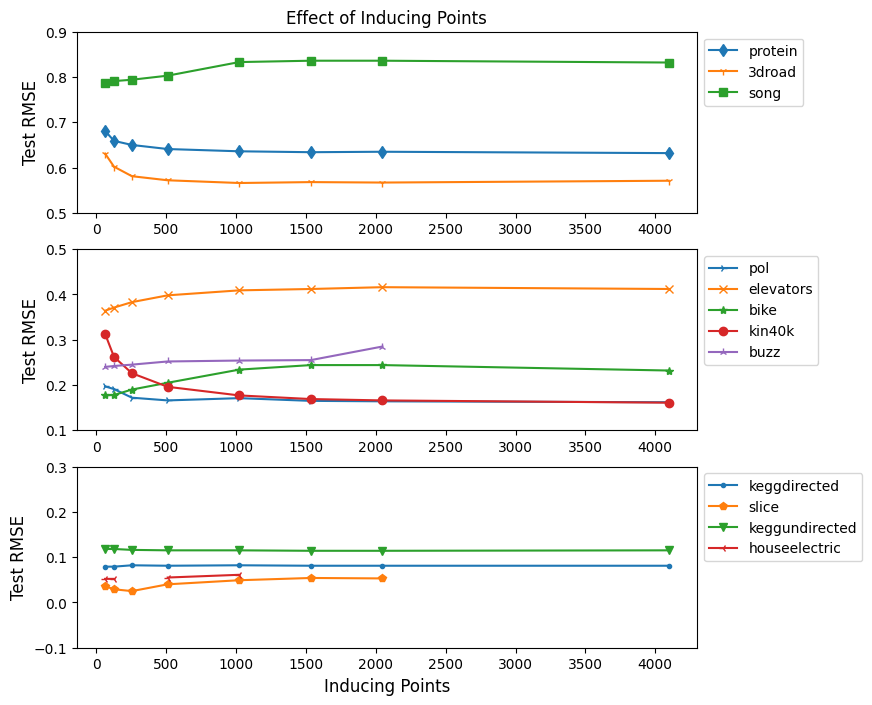

In [40]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8))
for dataset, _, _, _ in uci_info:
    # if dataset in ["3droad", "houseelectric", "keggundirected", "buzz", "song", "slice"]:
    #     continue
    if df_rmse.loc[dataset,:][0] < 0.15:
        ax = axs[2]
    elif df_rmse.loc[dataset,:][0] < 0.5:
        ax = axs[1]
    else:
        ax = axs[0]
    ax.plot(num_inducings, df_rmse.loc[dataset,:], label=dataset, marker=uci_markers[dataset])
# plt.legend()
FONTSIZE=12

axs[0].set_title("Effect of Inducing Points")
axs[0].set_ylim(0.5, 0.9)
axs[1].set_ylim(0.1, 0.5)
axs[2].set_ylim(-0.1, 0.3)
axs[2].set_xlabel("Inducing Points", fontsize=FONTSIZE)
for i in range(3):
    axs[i].set_ylabel("Test RMSE", fontsize=FONTSIZE)
# axs[0].set_tick_params(axis='both', labelsize=FONTSIZE)
    axs[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
# axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
# axs[2].legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig("inducing.png", bbox_inches='tight')
# plt.plot(num_inducings, df_rmse.loc["Kin40k",:])

In [ ]:
model = "soft-gp"
num_inducing = 512
frac = 0.9
seed = 6535

bin_df = pd.DataFrame()
bin_df[['N', 'D']] = df[['N', 'D']]
# bin_df.index = [name.capitalize().replace("_", "-") for name, _, _, _ in uci_info]
for model_num_inducing in ["soft-gp-64", "soft-gp-128", "soft-gp-256", "soft-gp-512", "soft-gp-1024", "soft-gp-1536", "soft-gp-2048", "soft-gp-4096"]:
    num_inducing = int(model_num_inducing.split("-")[-1])
    total = num_inducing**2
    for b in ["0.0", "1e-20", "1e-10", "1e-05", "0.01", "0.5"]:
        bin_df[f"{b}-{model_num_inducing}-{1024}-{seed}"] = np.array(all_bins[f"{b}-{model_num_inducing}-{1024}-{seed}"]) / total
    # bin_df[f"1e-20-{model}-{num_inducing}-{frac}-{seed}"] = np.array(all_bins[f"1e-20-{model}-{num_inducing}-{frac}-{seed}"]) / (512**2)
bin_df = bin_df.sort_values(by=['D'], ascending=[True])
bin_df

In [8]:
colors = COLORS * 2
markers = ['x', 'o', '.'] * 3

for dataset in ["3droad", "kin40k", "protein", "houseelectric", "bike", "elevators", "keggdirected", "pol", "keggundirected", "buzz", "song", "slice"]:
    plt.figure()
    for model_num_inducing, c, m in zip(["soft-gp-64", "soft-gp-128", "soft-gp-256", "soft-gp-512", "soft-gp-1024", "soft-gp-1536", "soft-gp-2048", "soft-gp-4096"], colors, markers):
        bs = ["0.0", "1e-20", "1e-10", "1e-05", "0.01", "0.5"]
        # model_num_inducing = "soft-gp-512"
        num_inducing = int(model_num_inducing.split("-")[-1])
        style = "-" if num_inducing <= 1024 else ":"
        plt.plot(bs, [bin_df[f"{b}-{model_num_inducing}-{1024}-{seed}"][dataset] for b in bs], label=num_inducing, marker=m, color=c, linestyle=style)
    plt.legend()
    plt.title("Inducing")
    plt.ylabel("Proportion")
    plt.xlabel("Kernel Value")
    plt.savefig(f"inducing/{dataset}.png")
    plt.close()

In [ ]:
UCI_INFO = {
    "N": [int(np.floor(N * 0.9)) for _, N, _, _ in uci_info],
    "D": [D for _, _, D, _ in uci_info],
    # "exact-rep": [e for _, _, _, e in uci_info],
}

seeds = [6535, 8830, 92357]
num_inducings = [64, 128, 256, 512, 1024, 1024 + 512, 2048, 4096]

# models = ["sv-gp"]
for seed in seeds:
    for num_inducing in num_inducings:
        model = "soft-gp"
        batch_size = 1024
        frac = 0.9
        xs = []
        ts = []
        K_zzs = []
        norm1 = []
        for dataset, _, _, _ in uci_info:
            try:
                xs += [float(uci_dict2[(dataset, batch_size, num_inducing, model)]["test_rmse"][49])]
                ts += [float(np.array(uci_dict2[(dataset, batch_size, num_inducing, model)]["epoch_time"][49]).mean())]
                K_zzs += [uci_dict2[(dataset, batch_size, num_inducing, model)]["K_zz"][i] for i in range(5)]
                norm1 += [float(uci_dict2[(dataset, batch_size, num_inducing, model)]["K_zz_norm_1"][49])]
            except Exception as e:
                xs += [np.nan]
                ts += [np.nan]
                norm1 += [np.nan]
                print("Exception", e, model, dataset)

        UCI_INFO[f"{model}-{num_inducing}-{batch_size}-{seed}"] = norm1
        # UCI_INFO[f"time-{model}-{num_inducing}-{batch_size}-{seed}"] = ts
df = pd.DataFrame(data=UCI_INFO)
df.index = [name for name, _, _, _ in uci_info]
# df.index = [name.capitalize().replace("_", "-") for name, _, _, _ in uci_info]
df

In [ ]:
def pm_var(df, model):
    m = df[[f'{model}-6535', f'{model}-8830', f'{model}-92357']].mean(axis=1).round(3)
    # v = df[[f'{model}-6535', f'{model}-8830', f'{model}-92357']].std(axis=1).round(3).astype(str).apply(lambda x: f" $\pm$ {x}")
    # return (m + v).apply(lambda x: x.replace("nan $\pm$ nan", "-"))
    return m
df_matnorm = pd.DataFrame()
df_matnorm[['N', 'D']] = df[['N', 'D']]
for model in ["soft-gp"]:
    for num_inducing in num_inducings:
        frac = 0.9
        df_matnorm[f'{model}-{num_inducing}-{1024}'] = pm_var(df, f'{model}-{num_inducing}-{1024}')

df_matnorm = df_matnorm.sort_values(by=['D'], ascending=[True])
df_matnorm = df_matnorm.drop(columns=['D', 'N'])
df_matnorm

In [ ]:
for dataset, _, _, _ in uci_info:
    # if dataset in ["3droad", "houseelectric", "keggundirected", "buzz", "song", "slice"]:
    #     continue
    plt.plot(num_inducings, np.log(df_matnorm.loc[dataset,:]), label=dataset, marker=uci_markers[dataset])
plt.legend()
plt.title("Effect of Inducing Points")
plt.xlabel("Inducing Points")
plt.ylabel("K_ZZ L1 Norm")
plt.savefig("inducing/matnorm.png")